In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import os
import dask.dataframe as ddf
import re
from scipy.stats import linregress

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path, filter_data_based_on_time

stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']

TinyTag_str = ['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5', 'TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8', 'TT1', 'TT2', 'TT3', 'TT4', 'TT5', 'TT6', 'TT7', 'TT9', 'TT12', 'TT13', 'TT14', 'TT15', 'TT16', 'TT17', 'TT18']

In [2]:
path = load_path()+'RawData/TinyTag/'

instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

# instrument_textbook_data['Station name']

# Formatting instrument textbook

This section of the code ensures consistency no matter what chnages in the excel file in sharepoint

In [3]:
# Extract station names (keep only prefix + number)
instrument_textbook_data['Formatted Name'] = [
    re.sub(r"(TT|TH|CEB)(\d+).*", r"\1\2", name) if re.match(r"(TT|TH|CEB)\d+", name) else name
    for name in instrument_textbook_data['Station name']
]

# Find duplicate names
duplicates = instrument_textbook_data['Formatted Name'].value_counts()
duplicate_names = duplicates[duplicates > 1].index  # Names that appear more than once

# Apply "_low" and "_high" based on "Th height (m)"
for name in duplicate_names:
    subset = instrument_textbook_data[instrument_textbook_data['Formatted Name'] == name]
    
    # Find the lowest and highest Th height
    min_index = subset['Th height (m)'].idxmin()
    max_index = subset['Th height (m)'].idxmax()
    
    # Rename them
    instrument_textbook_data.loc[min_index, 'Formatted Name'] = f"{name}_low"
    instrument_textbook_data.loc[max_index, 'Formatted Name'] = f"{name}_high"

# Get final formatted list
formatted_names = instrument_textbook_data['Formatted Name'].tolist()

# formatted_names

The following cell can ONLY be run once. If the following line soudl be 're-run', restart the kernal and run all

In [4]:
# Insert 'Formatted Name' as the first column
instrument_textbook_data.insert(0, 'Formatted Station Name', instrument_textbook_data.pop('Formatted Name'))

# Loading start and end times of Tinytag for calibration

In [5]:
# TinyTag_str = instrument_textbook_data['Station name'].tolist()
TinyTag_str = [s for s in formatted_names if s.startswith(("TT", "TH", "CEB"))]


# TinyTag_str

In [7]:
manual_times = {}

for station in TinyTag_str:
    setup_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Setup time (UTC)'].values[0])

    maintenance_start_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance start time (UTC)'].values[0])

    # maintenance_duration_idx = int(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0])
    maintenance_duration_value = instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0]
    maintenance_duration_idx = int(maintenance_duration_value) if not pd.isna(maintenance_duration_value) else 0

    retrieval_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Retrieval time (UTC)'].values[0])

    manual_times[station] = {
            'setup_time': setup_time_idx,
            'maintenance_start_time': maintenance_start_time_idx,
            'maintenance_duration': maintenance_duration_idx,
            'retrieval_time': retrieval_time_idx
        }

# manual_times

# Loading TinyTag  data

The TinyTag data is loaded using UNISasci function read_Tinytag(). The data is then loaded dynamically using load_TinyTag_folders() function (Alberte)

- Calibration data
    - ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
    - TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
    - TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

- Actual data
    - ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
    - TH_data = load_TinyTag_folders(path, 'TH', 'normal')
    - TT_data = load_TinyTag_folders(path, 'TT', 'normal')


Specific data is selected by:
- tag_data['tag_i_normal_data']
- tag_calibration_data['tag_i_calibration_data']

Where i corresponds to the TinyTag number in teh raw data folder



In [8]:
#function from unis github
def read_Tinytag(filename, sensor):
    '''
    Reads data from one or several data files from the Tinytag output files.

    Parameters:
    -------
    filename: str
        String with path to file(s)
        If several files shall be read, specify a string including UNIX-style wildcards
    sensor: str
        One of "TT", "TH" or "CEB"
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''

    import dask.dataframe as ddf


    if sensor == "TT":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T_black", "T_white"], encoding = "ISO-8859-1")
    elif sensor == "TH":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T", "RH"], encoding = "ISO-8859-1")
    elif sensor == "CEB":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T"], encoding = "ISO-8859-1")
    else:
        assert False, 'Sensortype of Tinytag not known. Should be one of "TT", "TH" or "CEB".'

    df = df.compute()
    df.set_index("TIMESTAMP", inplace=True)

    for key in list(df.columns):
        if key == "RECORD":
            pass
        else:
            data = [float(i.split(" ")[0]) for i in df[key]]
            unit = df[key].iloc[0].split(" ")[1]
            if unit == "°C":
                unit = "degC"
            new_key = f"{key}_{unit}"

            df[new_key] = data

            df.drop(key, axis=1, inplace=True)

    return df

In [8]:
# # Get all CEB_i folders inside TinyTag
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('CEB_')]

# # Dictionary to store the datasets
# calibration_data = {}

# # Loop through each CEB_i folder
# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "CEB_i_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'CEB')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# # Loop over the stored datasets and assign them as individual variables
# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [9]:
# # TH
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TH')]

# # Dictionary to store the datasets
# calibration_data = {}

# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "THi_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'TH')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [10]:
# # TT
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TT')]

# # Dictionary to store the datasets
# calibration_data = {}

# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "TTi_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'TT')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [9]:
def load_TinyTag_folders(path, tag, datatype):
    """
    Processes folders that start with a specific prefix, reads corresponding files,
    and stores their datasets in a dictionary.
    """
    # prefix = 0
    # prefix = []
    if tag == 'CEB':
        prefix = 'CEB_'
    elif tag == 'TH':
        prefix = 'TH'
    elif tag == 'TT':
        prefix = 'TT'

    if datatype == 'calibration':
        folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
        calibration_data = {}

        for folder in folders:
            folder_path = os.path.join(path, folder)
            files = [f for f in os.listdir(folder_path) if f.startswith(f"{folder}_calibration_") and f.endswith(".txt")]
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                calibration_data[f"{folder}_calibration_data"] = dataset
        
        return calibration_data
    
    elif datatype == 'normal':
        folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
        normal_data = {}

        for folder in folders:
            folder_path = os.path.join(path, folder)
            # Filter files that DO NOT contain "_calibration" in their name
            files = [f for f in os.listdir(folder_path) if "_calibration" not in f and f.endswith(".txt")]
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                normal_data[f"{folder}_normal_data"] = dataset  # Different key to distinguish

        return normal_data

        
# # Process all folder types
# all_data = {}
# for prefix, tag in zip(["CEB_", "TH", "TT"], ["CEB", "TH", "TT"]):
#     all_data.update(load_TinyTag_folders(path, prefix, tag))

# # Assign the datasets to global variables
# globals().update(all_data)


In [10]:
ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
TH_data = load_TinyTag_folders(path, 'TH', 'normal')
TT_data = load_TinyTag_folders(path, 'TT', 'normal')

Formatting the data to remove the seconds - yielding format yyyy-mm-dd h:m

In [11]:
datasets = [ceb_calibration_data, TH_calibration_data, TT_calibration_data,
            ceb_data, TH_data, TT_data]

# Loop through each dataset
for dataset in datasets:
    for key in dataset.keys():  # Iterate over each DataFrame inside the dictionary
        dataset[key].index = dataset[key].index.round('min')
        # dataset[key].index = pd.to_datetime(dataset[key].index.strftime('%Y-%m-%d %H:%M'))


In [12]:
ceb_calibration_data['CEB_1_calibration_data'].index

DatetimeIndex(['2025-01-24 09:31:00', '2025-01-24 09:32:00',
               '2025-01-24 09:33:00', '2025-01-24 09:34:00',
               '2025-01-24 09:35:00', '2025-01-24 09:36:00',
               '2025-01-24 09:37:00', '2025-01-24 09:38:00',
               '2025-01-24 09:39:00', '2025-01-24 09:40:00',
               ...
               '2025-01-25 15:32:00', '2025-01-25 15:33:00',
               '2025-01-25 15:34:00', '2025-01-25 15:35:00',
               '2025-01-25 15:36:00', '2025-01-25 15:37:00',
               '2025-01-25 15:38:00', '2025-01-25 15:39:00',
               '2025-01-25 15:40:00', '2025-01-25 15:41:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=1811, freq=None)

# Filtering data based on setup and retrival times

Filter calibration data based on manual inspection of plotted data

In [13]:
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

Text(0.5, 0, 'Time')

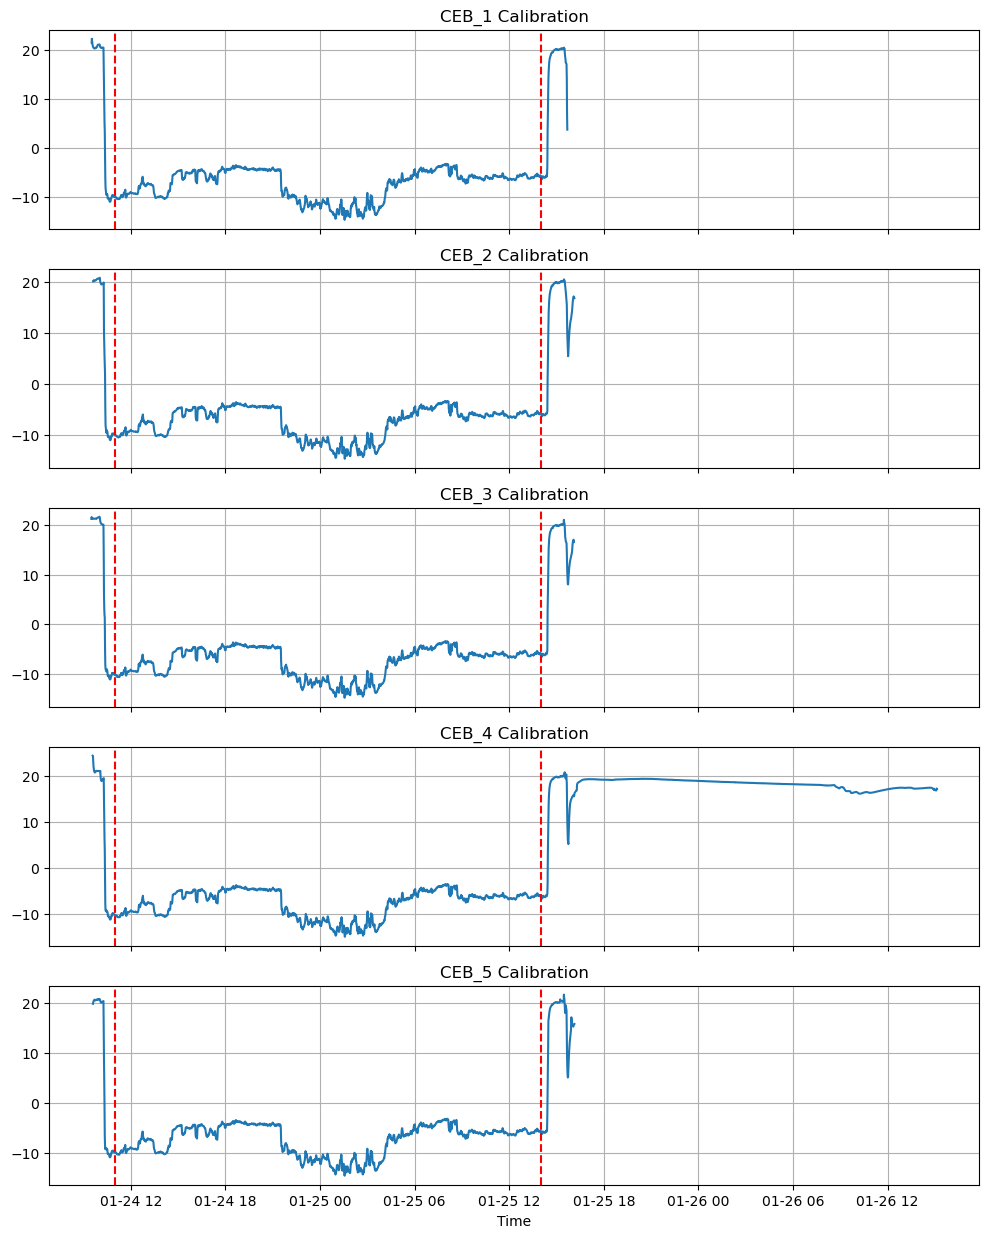

In [14]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# Example plotting each dataset in a different subplot
ax[0].plot(ceb_calibration_data['CEB_1_calibration_data'].index, 
           ceb_calibration_data['CEB_1_calibration_data'].T_degC, label='CEB_1')
ax[0].set_title("CEB_1 Calibration")

ax[1].plot(ceb_calibration_data['CEB_2_calibration_data'].index, 
           ceb_calibration_data['CEB_2_calibration_data'].T_degC, label='CEB_2')
ax[1].set_title("CEB_2 Calibration")

ax[2].plot(ceb_calibration_data['CEB_3_calibration_data'].index, 
           ceb_calibration_data['CEB_3_calibration_data'].T_degC, label='CEB_3')
ax[2].set_title("CEB_3 Calibration")

ax[3].plot(ceb_calibration_data['CEB_4_calibration_data'].index, 
           ceb_calibration_data['CEB_4_calibration_data'].T_degC, label='CEB_4')
ax[3].set_title("CEB_4 Calibration")

ax[4].plot(ceb_calibration_data['CEB_5_calibration_data'].index, 
           ceb_calibration_data['CEB_5_calibration_data'].T_degC, label='CEB_5')
ax[4].set_title("CEB_5 Calibration")

for a in ax:
    a.axvline(x = calibration_filter_start_date, color='red', linestyle='--')
    a.axvline(x = calibration_filter_end_date, color='red', linestyle='--')
    a.grid(True)

ax[-1].set_xlabel("Time")  # Set x-axis label on the last subplot

Remove data beofore and after red lines

In [15]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in ceb_calibration_data.keys():
    df = ceb_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    ceb_calibration_data[key] = filtered_df


plot filtered CEB calibration data

Text(0.5, 0, 'Time')

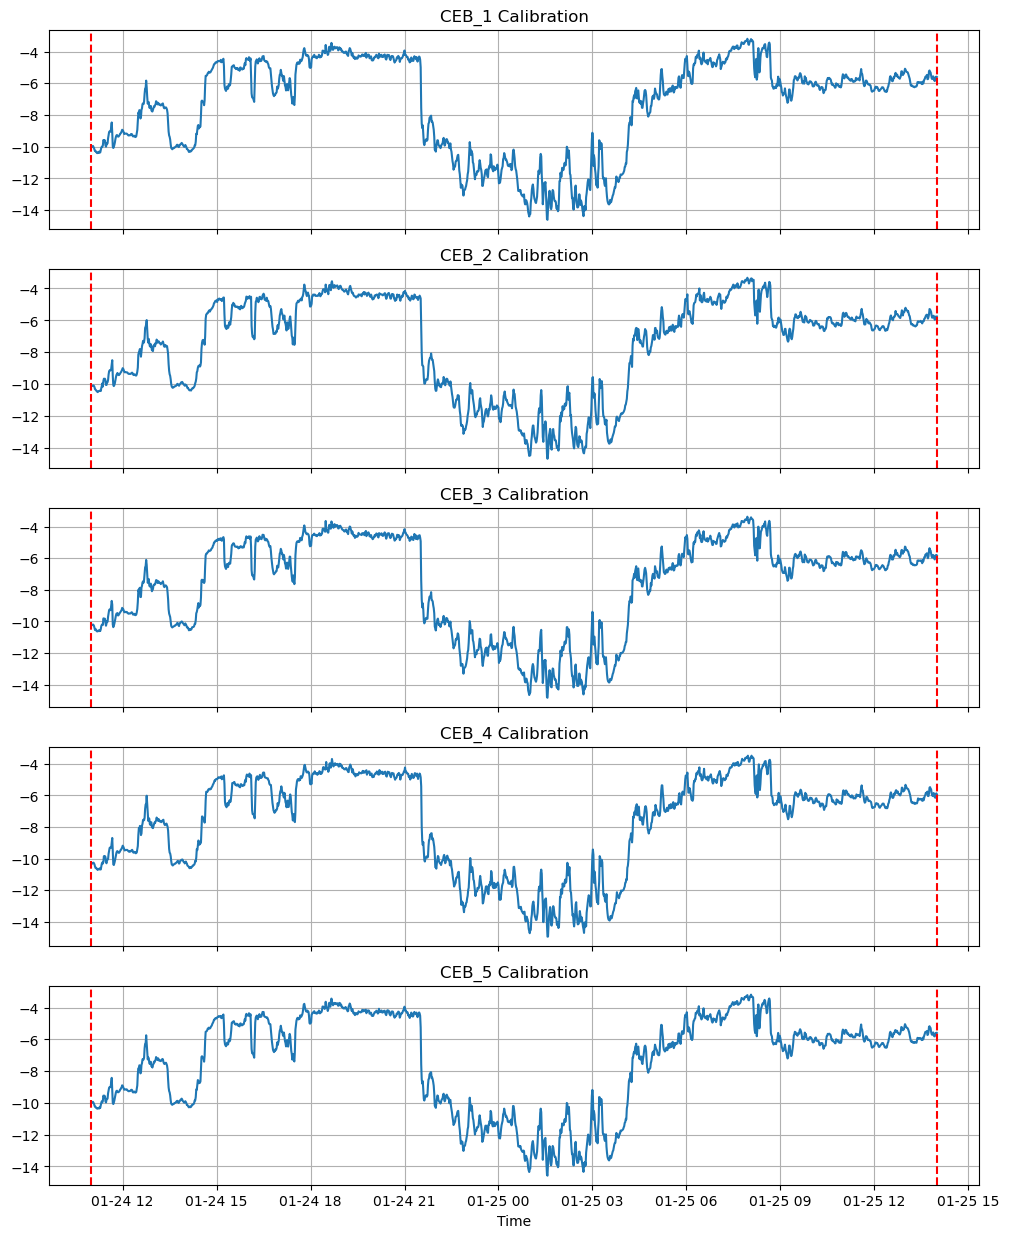

In [16]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# Example plotting each dataset in a different subplot
ax[0].plot(ceb_calibration_data['CEB_1_calibration_data'].index, 
           ceb_calibration_data['CEB_1_calibration_data'].T_degC, label='CEB_1')
ax[0].set_title("CEB_1 Calibration")

ax[1].plot(ceb_calibration_data['CEB_2_calibration_data'].index, 
           ceb_calibration_data['CEB_2_calibration_data'].T_degC, label='CEB_2')
ax[1].set_title("CEB_2 Calibration")

ax[2].plot(ceb_calibration_data['CEB_3_calibration_data'].index, 
           ceb_calibration_data['CEB_3_calibration_data'].T_degC, label='CEB_3')
ax[2].set_title("CEB_3 Calibration")

ax[3].plot(ceb_calibration_data['CEB_4_calibration_data'].index, 
           ceb_calibration_data['CEB_4_calibration_data'].T_degC, label='CEB_4')
ax[3].set_title("CEB_4 Calibration")

ax[4].plot(ceb_calibration_data['CEB_5_calibration_data'].index, 
           ceb_calibration_data['CEB_5_calibration_data'].T_degC, label='CEB_5')
ax[4].set_title("CEB_5 Calibration")

for a in ax:
    a.axvline(x = calibration_filter_start_date, color='red', linestyle='--')
    a.axvline(x = calibration_filter_end_date, color='red', linestyle='--')
    a.grid(True)

ax[-1].set_xlabel("Time")  # Set x-axis label on the last subplot

In [19]:
manual_times['TT12_low']

{'setup_time': Timestamp('2025-01-26 13:56:00'),
 'maintenance_start_time': NaT,
 'maintenance_duration': 0,
 'retrieval_time': Timestamp('2025-02-03 12:55:00')}

In [21]:
ceb_calibration_data['CEB_1_calibration_data']

,RECORD,T_degC
TIMESTAMP,,
2025-01-24 11:00:00,90,-10.02
2025-01-24 11:01:00,91,-10.02
2025-01-24 11:02:00,92,-10.00
2025-01-24 11:03:00,93,-9.95
2025-01-24 11:04:00,94,-10.01
...,...,...
2025-01-25 13:56:00,1706,-5.86
2025-01-25 13:57:00,1707,-5.67
2025-01-25 13:58:00,1708,-5.59


my additions:

                     T_degC_avg
TIMESTAMP                      
2025-01-24 11:00:00     -10.128
2025-01-24 11:01:00     -10.132
2025-01-24 11:02:00     -10.118
2025-01-24 11:03:00     -10.084
2025-01-24 11:04:00     -10.108


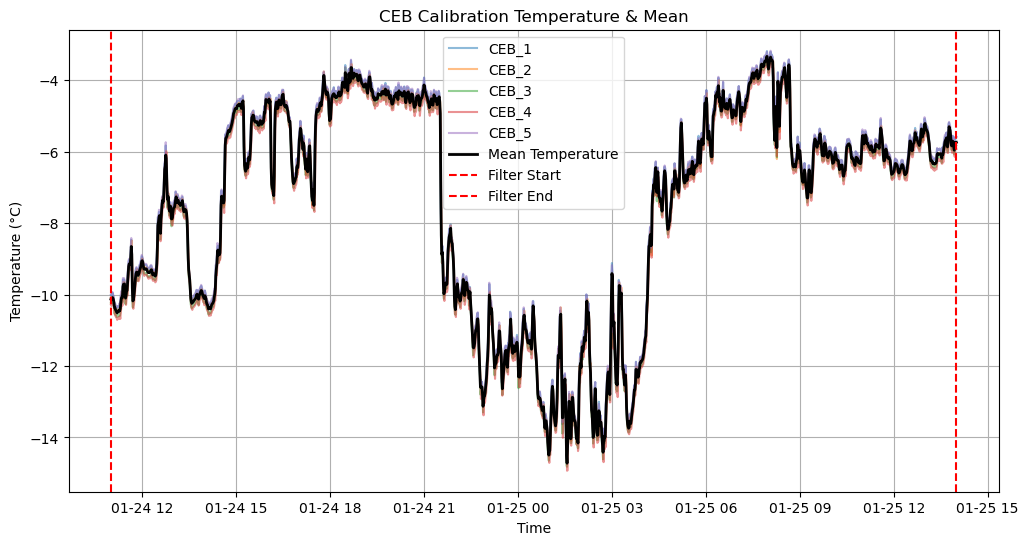

In [17]:

# Define start and end times for filtering
#calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
#calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

# Initialize the DataFrame with the first dataset
df_avg = ceb_calibration_data['CEB_1_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_1'})

# Merge with the other CEB datasets using Timestamp as the index
df_avg = df_avg.merge(ceb_calibration_data['CEB_2_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_2'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_3_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_3'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_4_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_4'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_5_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_5'}),
                      left_index=True, right_index=True, how='outer')

# **Calculate mean temperature per timestamp**
df_avg['T_degC_avg'] = df_avg[['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5']].mean(axis=1, skipna=True)

# **Filter the dataset within the defined time range**
#df_avg = df_avg[(df_avg.index >= calibration_filter_start_date) & (df_avg.index <= calibration_filter_end_date)]

# **Keep only the Timestamp index and the mean temperature column**
df_avg = df_avg[['T_degC_avg']]

# **Preview the calculated means**
print(df_avg.head())

# **Plot the CEB temperature data and the mean**
plt.figure(figsize=(12, 6))

# Plot individual CEB temperature data with transparency
plt.plot(df_avg.index, ceb_calibration_data['CEB_1_calibration_data']['T_degC'], label='CEB_1', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_2_calibration_data']['T_degC'], label='CEB_2', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_3_calibration_data']['T_degC'], label='CEB_3', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_4_calibration_data']['T_degC'], label='CEB_4', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_5_calibration_data']['T_degC'], label='CEB_5', alpha=0.5)

# **Plot the mean temperature with a bold line**
plt.plot(df_avg.index, df_avg['T_degC_avg'], label='Mean Temperature', color='black', linewidth=2)

# **Add vertical lines for the filtering window**
plt.axvline(x=calibration_filter_start_date, color='red', linestyle='--', label="Filter Start")
plt.axvline(x=calibration_filter_end_date, color='red', linestyle='--', label="Filter End")

# **Format the plot**
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("CEB Calibration Temperature & Mean")
plt.legend(loc="best")
plt.grid(True)

# **Show the plot**
plt.show()


In [23]:
print(df_avg.columns)
###

Index(['T_degC_avg'], dtype='object')


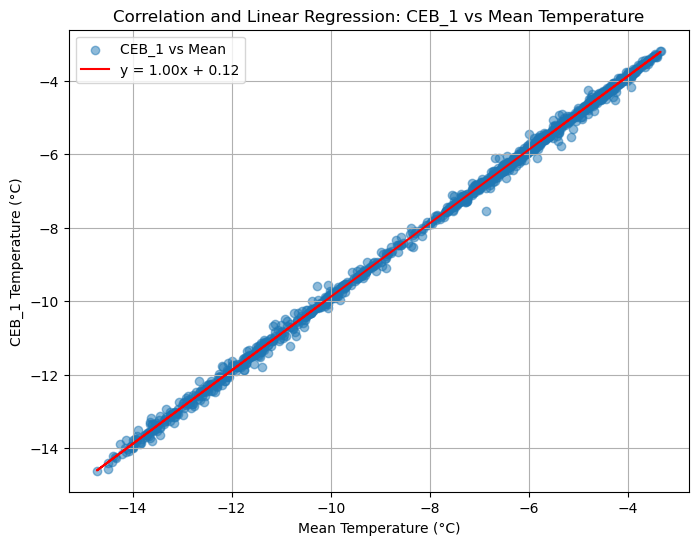

CEB_1 Linear Regression: y = 1.00x + 0.12


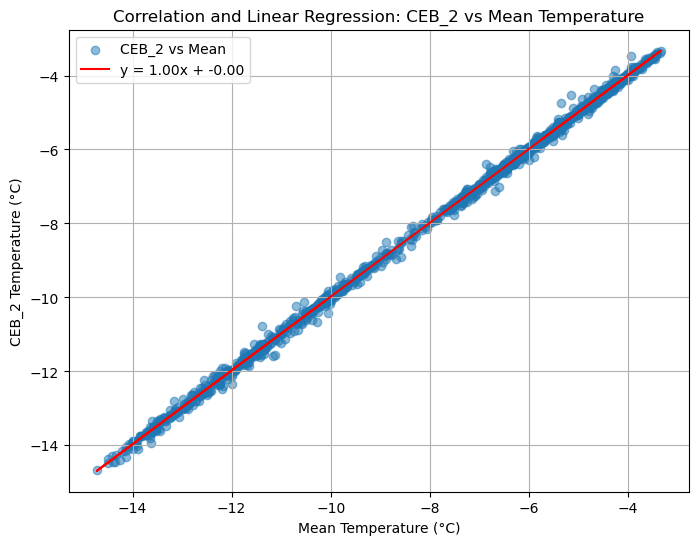

CEB_2 Linear Regression: y = 1.00x + -0.00


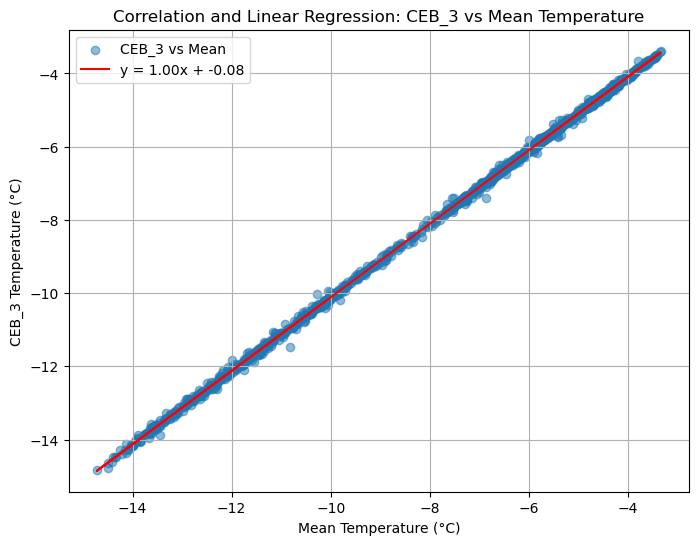

CEB_3 Linear Regression: y = 1.00x + -0.08


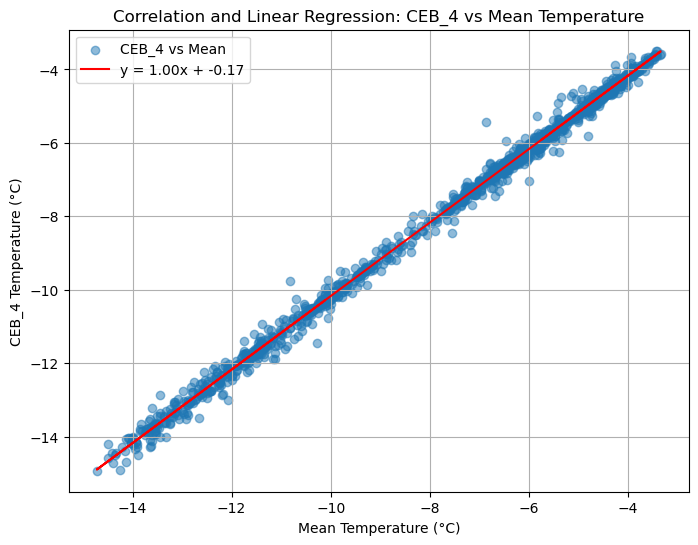

CEB_4 Linear Regression: y = 1.00x + -0.17


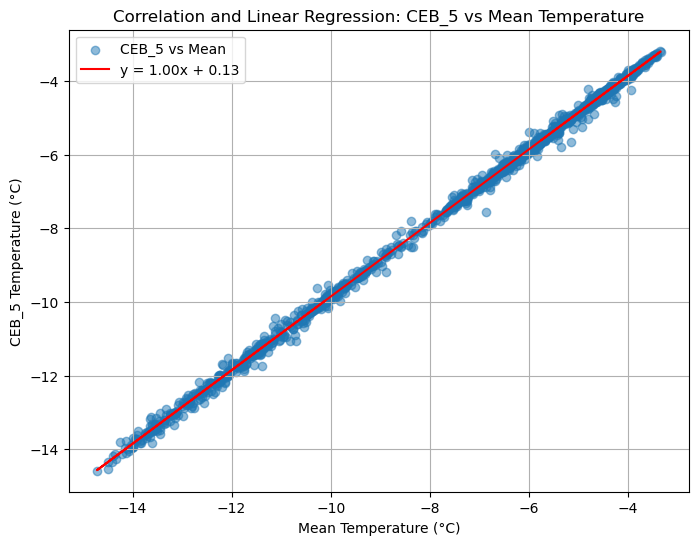

CEB_5 Linear Regression: y = 1.00x + 0.13


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the start and end dates for filtering
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

# List of CEB calibration data variables
ceb_data_stations = [
    ceb_calibration_data['CEB_1_calibration_data'],
    ceb_calibration_data['CEB_2_calibration_data'],
    ceb_calibration_data['CEB_3_calibration_data'],
    ceb_calibration_data['CEB_4_calibration_data'],
    ceb_calibration_data['CEB_5_calibration_data']
]

# Filter the datasets based on the specified start and end dates
filtered_ceb_data_stations = [
    df.loc[calibration_filter_start_date:calibration_filter_end_date, 'T_degC'] for df in ceb_data_stations
]

# Combine all filtered CEB datasets into a single DataFrame
combined_df = pd.concat(filtered_ceb_data_stations, axis=1)
combined_df.columns = ['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5']

# Calculate the mean temperature per timestep
mean_temp = combined_df.mean(axis=1)

# Store the regression models
regression_models = {}

# Plot correlation of each CEB dataset against the mean temperature
for station in combined_df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp, combined_df[station], alpha=0.5, label=f"{station} vs Mean")
    
    # Perform linear regression
    x = mean_temp.values.reshape(-1, 1)
    y = combined_df[station].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Store the regression model
    regression_models[station] = model
    

    # Plot the regression line
    plt.plot(mean_temp, y_pred, color="red", label=f"y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")
    
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Correlation and Linear Regression: {station} vs Mean Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the regression coefficients
    print(f"{station} Linear Regression: y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")

# Calibrate the CEB data

In [42]:
import re
import pandas as pd

"""
# Define the function to filter data based on time
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            if matching_keys:
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                maintenance_end = maintenance_start + pd.Timedelta(minutes=maintenance_duration) if pd.notna(maintenance_start) else None

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]
                
                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))]

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data



# Define the function to filter data based on time
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            if matching_keys:
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                maintenance_end = maintenance_start + pd.Timedelta(minutes=maintenance_duration) if pd.notna(maintenance_start) else None

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]
                
                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))]

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data
    """

<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rebec\AppData\Local\Temp\ipykernel_33812\3858378621.py:49: SyntaxWarning: invalid escape sequence '\d'
  """


'\n# Define the function to filter data based on time\ndef filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):\n    filtered_data = {}\n\n    for key, df in data_dict.items():\n        # Extract the numeric identifier based on the dataset prefix\n        if prefix == "TT":\n            match = re.search(r\'TT(\\d+)\', key)\n        elif prefix == "TH":\n            match = re.search(r\'TH(\\d+)\', key)\n        elif prefix == "CEB":\n            match = re.search(r\'CEB_(\\d+)\', key)\n        else:\n            match = None\n\n        dataset_id = match.group(1) if match else None\n\n        if dataset_id:\n            # Look for a matching key in manual_times\n            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]\n\n            if matching_keys:\n                manual_key = matching_keys[0]\n                times = manual_times[manual_key]\n\n                setup_time = times[\'setup_time\']\n               

In [19]:
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            # Debugging prints
            print(f"Dataset Key: {key}")
            print(f"Extracted Dataset ID: {dataset_id}")
            print(f"Matching Keys in manual_times: {matching_keys}")

            if matching_keys:
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                maintenance_end = (
                    maintenance_start + pd.Timedelta(minutes=maintenance_duration)
                    if pd.notna(maintenance_start)
                    else None
                )

                # Debugging prints for filtering
                print(f"Filtering {key} with Setup Time: {setup_time}, Retrieval Time: {retrieval_time}")
                print(f"Maintenance Start: {maintenance_start}, Maintenance End: {maintenance_end}")

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]

                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[
                        ~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))
                    ]

                # Debugging print for filtered data shape
                print(f"Filtered Data Shape for {key}: {df_filtered.shape}")

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data


In [20]:
print("Filtered CEB Data Keys:", filtered_ceb_data.keys())
for key, df in filtered_ceb_data.items():
    print(f"{key}: {df.shape}")  # Check shapes to ensure all datasets have data

print("Calibrated CEB Data Keys:", calibrated_ceb_data.keys())
for key, df in calibrated_ceb_data.items():
    print(f"{key}: {df.shape}")

# Debugging: Print all keys in `manual_times`
    print("Keys in manual_times:", manual_times.keys())

NameError: name 'filtered_ceb_data' is not defined

In [48]:
print("Stations in CEB Data:", ceb_data.keys())
print("Regression Model Keys:", regression_models.keys())


Stations in CEB Data: dict_keys(['CEB_1_normal_data', 'CEB_2_normal_data', 'CEB_3_normal_data', 'CEB_4_normal_data', 'CEB_5_normal_data'])
Regression Model Keys: dict_keys(['CEB_1_normal_data', 'CEB_2_normal_data', 'CEB_3_normal_data', 'CEB_4_normal_data', 'CEB_5_normal_data'])


In [54]:
print("Key in data_dict:", key)
print("Matching Keys in manual_times:", matching_keys)


Key in data_dict: CEB_3_normal_data


NameError: name 'matching_keys' is not defined

apply regression models

In [43]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Define the function to calibrate the CEB datasets
def calibrate_ceb_data(ceb_data, regression_models):
    calibrated_data = {}

    for station, df in ceb_data.items():
        if station in regression_models:
            model = regression_models[station]
            df['Calibrated_Temperature'] = df['T_degC'].apply(lambda x: model.predict([[x]])[0][0] if not np.isnan(x) else np.nan)
            calibrated_data[station] = df

    return calibrated_data
"""
# Define the function to calibrate the CEB datasets
def calibrate_ceb_data(ceb_data, regression_models):
    calibrated_data = {}

    for station, df in ceb_data.items():
        if station in regression_models:
            model = regression_models[station]
            df['Calibrated_Temperature'] = df['T_degC'].apply(lambda x: model.predict([[x]])[0][0] if not np.isnan(x) else np.nan)
            calibrated_data[station] = df

    return calibrated_data

# Example usage
# Assuming you have the following variables defined:
# ceb_data: Dictionary containing the CEB datasets
# manual_times: Dictionary containing the setup, maintenance, and retrieval times

# Filter the CEB datasets
filtered_ceb_data = filter_data_based_on_time_tinytag(ceb_data, manual_times, 'CEB')

# Calibrate the filtered CEB datasets
calibrated_ceb_data = calibrate_ceb_data(filtered_ceb_data, regression_models)

# Print the calibrated data
for station, df in calibrated_ceb_data.items():
    print(f"Calibrated data for {station}:")
    print(df.head())
    """

'\n# Define the function to calibrate the CEB datasets\ndef calibrate_ceb_data(ceb_data, regression_models):\n    calibrated_data = {}\n\n    for station, df in ceb_data.items():\n        if station in regression_models:\n            model = regression_models[station]\n            df[\'Calibrated_Temperature\'] = df[\'T_degC\'].apply(lambda x: model.predict([[x]])[0][0] if not np.isnan(x) else np.nan)\n            calibrated_data[station] = df\n\n    return calibrated_data\n\n# Example usage\n# Assuming you have the following variables defined:\n# ceb_data: Dictionary containing the CEB datasets\n# manual_times: Dictionary containing the setup, maintenance, and retrieval times\n\n# Filter the CEB datasets\nfiltered_ceb_data = filter_data_based_on_time_tinytag(ceb_data, manual_times, \'CEB\')\n\n# Calibrate the filtered CEB datasets\ncalibrated_ceb_data = calibrate_ceb_data(filtered_ceb_data, regression_models)\n\n# Print the calibrated data\nfor station, df in calibrated_ceb_data.items

Filtered CEB Data:
CEB_3_normal_data: (11456, 2)
                     RECORD  T_degC
TIMESTAMP                          
2025-01-26 14:00:00     317   -5.24
2025-01-26 14:01:00     318   -5.25
2025-01-26 14:02:00     319   -5.05
2025-01-26 14:03:00     320   -3.88
2025-01-26 14:04:00     321   -4.18


C:\Users\rebec\AppData\Local\Temp\ipykernel_33812\3039277986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Calibrated_Temperature'] = df['T_degC'].apply(lambda x: model.predict([[x]])[0][0] if not np.isnan(x) else np.nan)


Calibrated CEB Data:
CEB_3_normal_data: (11456, 3)
                     RECORD  T_degC  Calibrated_Temperature
TIMESTAMP                                                  
2025-01-26 14:00:00     317   -5.24                   -5.32
2025-01-26 14:01:00     318   -5.25                   -5.33
2025-01-26 14:02:00     319   -5.05                   -5.13
2025-01-26 14:03:00     320   -3.88                   -3.96
2025-01-26 14:04:00     321   -4.18                   -4.26


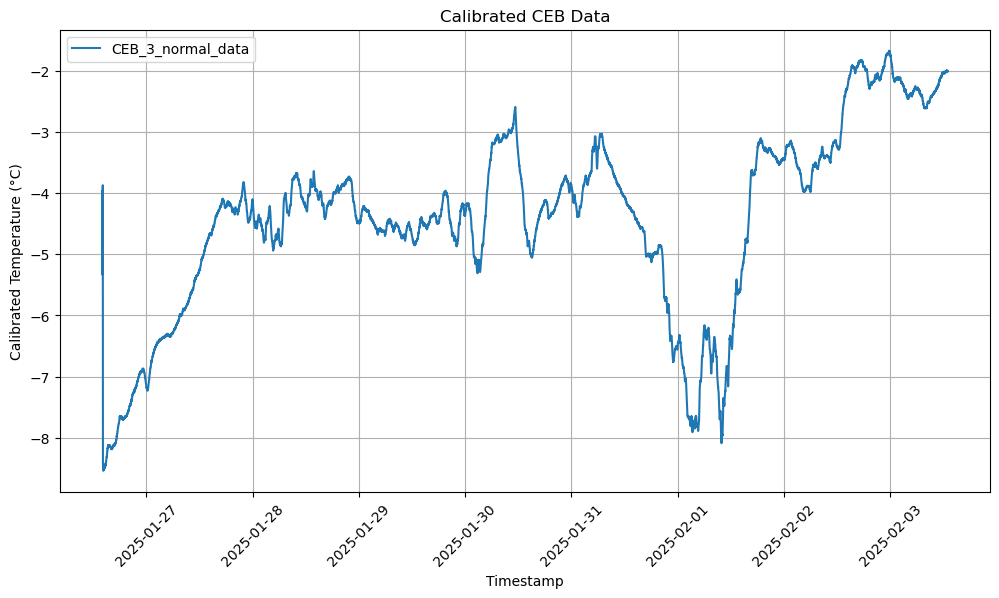

Saved calibrated data for CEB_3_normal_data to CEB_3_normal_data_calibrated_data.csv


In [44]:
import matplotlib.pyplot as plt
import os

# Example usage
# Assuming you have the following variables defined:
# ceb_data: Dictionary containing the CEB datasets
# manual_times: Dictionary containing the setup, maintenance, and retrieval times

# Filter the CEB datasets
filtered_ceb_data = filter_data_based_on_time_tinytag(ceb_data, manual_times, 'CEB')

# Debug print to check filtered data
print("Filtered CEB Data:")
for station, df in filtered_ceb_data.items():
    print(f"{station}: {df.shape}")
    print(df.head())  # Print the first few rows to check the columns

# Manually specify the linear regression models for each CEB dataset
regression_models = {
    'CEB_1_normal_data': LinearRegression().fit(np.array([[0], [1]]), np.array([[0.12], [1.12]])),
    'CEB_2_normal_data': LinearRegression().fit(np.array([[0], [1]]), np.array([[0], [1]])),
    'CEB_3_normal_data': LinearRegression().fit(np.array([[0], [1]]), np.array([[-0.08], [0.92]])),
    'CEB_4_normal_data': LinearRegression().fit(np.array([[0], [1]]), np.array([[-0.17], [0.83]])),
    'CEB_5_normal_data': LinearRegression().fit(np.array([[0], [1]]), np.array([[0.13], [1.13]]))
}

# Calibrate the filtered CEB datasets
calibrated_ceb_data = calibrate_ceb_data(filtered_ceb_data, regression_models)

# Debug print to check calibrated data
print("Calibrated CEB Data:")
for station, df in calibrated_ceb_data.items():
    print(f"{station}: {df.shape}")
    print(df.head())  # Print the first few rows to check the columns

# Plot the calibrated data
plt.figure(figsize=(12, 6))
for station, df in calibrated_ceb_data.items():
    plt.plot(df.index, df['Calibrated_Temperature'], label=station)

plt.xlabel("Timestamp")
plt.ylabel("Calibrated Temperature (°C)")
plt.title("Calibrated CEB Data")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Save the calibrated datasets to files
file_path = 'CalibratedData/AWS/'  # Adjust this path as needed
os.makedirs(file_path, exist_ok=True)

for station, df in calibrated_ceb_data.items():
    file_name = f"{station}_calibrated_data.csv"
    df.to_csv(os.path.join(file_path, file_name), index=True)
    print(f"Saved calibrated data for {station} to {file_name}")

plot data

In [46]:
# Save the calibrated datasets to files
file_path = 'CalibratedData/Tinytags/'  # Adjust this path as needed
os.makedirs(file_path, exist_ok=True)

for station, df in calibrated_ceb_data.items():
    file_name = f"{station}_calibrated_data.csv"
    df.to_csv(os.path.join(file_path, file_name), index=True)
    print(f"Saved calibrated data for {station} to {file_name}")
    

Saved calibrated data for CEB_3_normal_data to CEB_3_normal_data_calibrated_data.csv
CEB_3_normal_data has no data to save.


In [38]:
calibrated_ceb_data

{'CEB_3_normal_data':                      RECORD  T_degC  Calibrated_Temperature
 TIMESTAMP                                                  
 2025-01-26 14:00:00     317   -5.24                   -5.32
 2025-01-26 14:01:00     318   -5.25                   -5.33
 2025-01-26 14:02:00     319   -5.05                   -5.13
 2025-01-26 14:03:00     320   -3.88                   -3.96
 2025-01-26 14:04:00     321   -4.18                   -4.26
 ...                     ...     ...                     ...
 2025-02-03 12:51:00   11768   -1.93                   -2.01
 2025-02-03 12:52:00   11769   -1.94                   -2.02
 2025-02-03 12:53:00   11770   -1.92                   -2.00
 2025-02-03 12:54:00   11771   -1.93                   -2.01
 2025-02-03 12:55:00   11772   -1.92                   -2.00
 
 [11456 rows x 3 columns]}

plot the filtered data

## **Filter TH Tinytags**

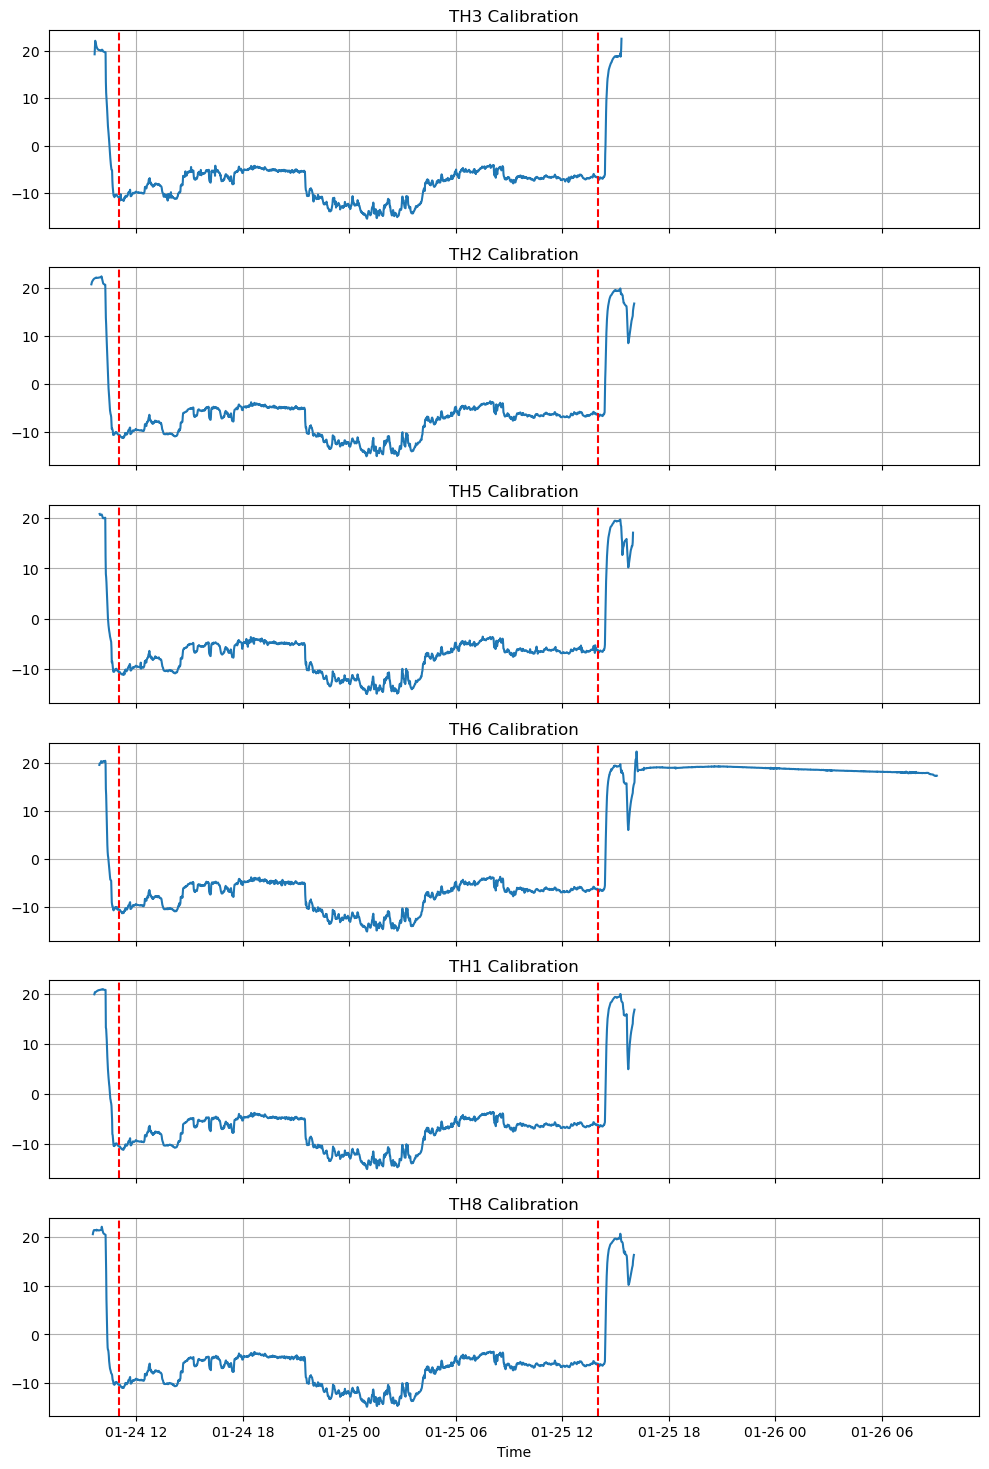

In [31]:
### plot raw data
# Get all dataset keys dynamically based on TinyTag_str
dataset_keys = [f"{tag}_calibration_data" for tag in TinyTag_str if tag.startswith("TH") and f"{tag}_calibration_data" in TH_calibration_data]

# # Adjust nrows based on the actual number of TH datasets
fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
if len(dataset_keys) == 1:
     ax = [ax]

# # Loop through each subplot and dataset
for i, key in enumerate(dataset_keys):
     ax[i].plot(TH_calibration_data[key].index, 
               TH_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
     ax[-1].set_xlabel("Time")


remove TH data before and after red lines

In [32]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in TH_calibration_data.keys():
    df = TH_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    TH_calibration_data[key] = filtered_df


plot filtered TH calibration data

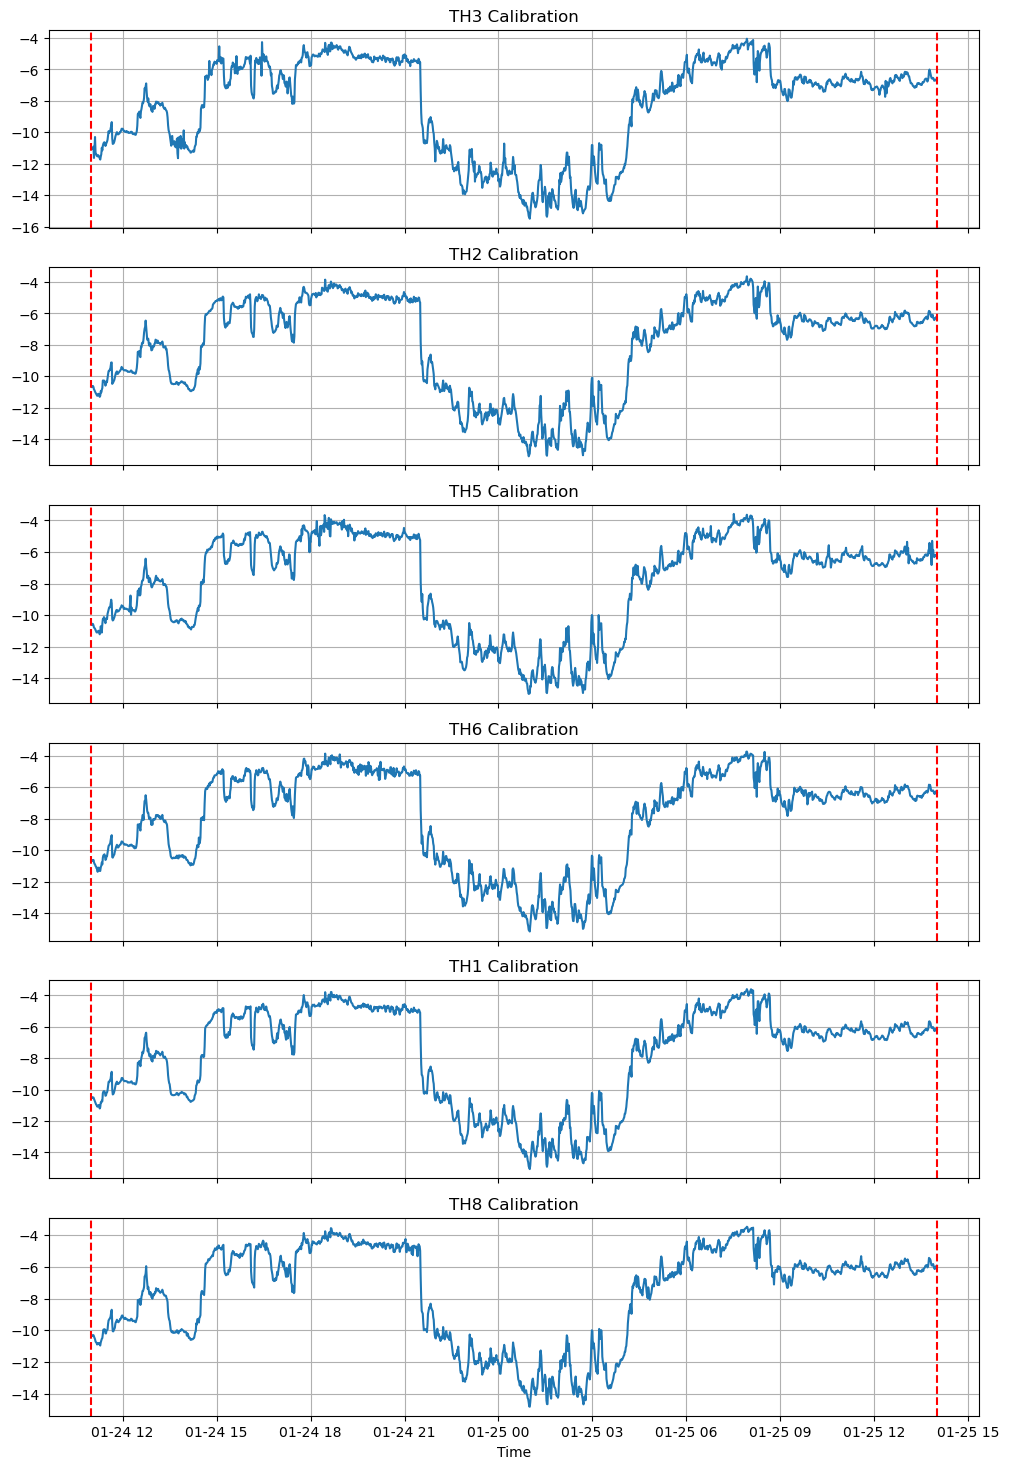

In [ ]:
# # Get all dataset keys dynamically based on TinyTag_str
dataset_keys = [f"{tag}_calibration_data" for tag in TinyTag_str if tag.startswith("TH") and f"{tag}_calibration_data" in TH_calibration_data]

# # Adjust nrows based on the actual number of TH datasets
fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
if len(dataset_keys) == 1:
    ax = [ax]

# # Loop through each subplot and dataset
for i, key in enumerate(dataset_keys):
     ax[i].plot(TH_calibration_data[key].index, 
                TH_calibration_data[key].T_degC, label=key.replace("_calibration_data", ""))
     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
     import pandas as pd
     import matplotlib.pyplot as plt
     from sklearn.linear_model import LinearRegression
     
     # Define the start and end dates for filtering
     calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
     calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')
     
     # List of TH calibration data variables
     th_data_stations = [
         TH_calibration_data['TH1_calibration_data'],
         TH_calibration_data['TH2_calibration_data'],
         TH_calibration_data['TH3_calibration_data'],
         TH_calibration_data['TH4_calibration_data'],
         TH_calibration_data['TH5_calibration_data'],
         TH_calibration_data['TH6_calibration_data'],
         TH_calibration_data['TH7_calibration_data'],
         TH_calibration_data['TH8_calibration_data']
     ]
     
     # Filter the datasets based on the specified start and end dates
     filtered_th_data_stations = [
         df.loc[calibration_filter_start_date:calibration_filter_end_date, 'T_degC'] for df in th_data_stations
     ]
     
     # Combine all filtered TH datasets into a single DataFrame
     combined_df = pd.concat(filtered_th_data_stations, axis=1)
     combined_df.columns = ['TH1', 'TH2', 'TH3', 'TH4', 'TH5', 'TH6', 'TH7', 'TH8']
     
     # Calculate the mean temperature per timestep
     mean_temp = combined_df.mean(axis=1)
     
     # Plot all filtered TH datasets together
     plt.figure(figsize=(12, 6))
     for station in combined_df.columns:
         plt.plot(combined_df.index, combined_df[station], label=station)
     
     # Add the mean temperature to the plot
     plt.plot(mean_temp.index, mean_temp, label="Mean Temperature", color="black", linewidth=2)
     
     plt.xlabel("Timestamp")
     plt.ylabel("Temperature (°C)")
     plt.title("Filtered TH Calibration Datasets and Mean Temperature")
     plt.legend(loc='best')
     plt.grid(True)
     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
     plt.show()
     
     # Plot correlation of each TH dataset against the mean temperature
     for station in combined_df.columns:
         plt.figure(figsize=(8, 6))
         plt.scatter(mean_temp, combined_df[station], alpha=0.5, label=f"{station} vs Mean")
         
         # Perform linear regression
         x = mean_temp.values.reshape(-1, 1)
         y = combined_df[station].values.reshape(-1, 1)
         model = LinearRegression()
         model.fit(x, y)
         y_pred = model.predict(x)
         
         # Plot the regression line
         plt.plot(mean_temp, y_pred, color="red", label=f"y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")
         
         plt.xlabel("Mean Temperature (°C)")
         plt.ylabel(f"{station} Temperature (°C)")
         plt.title(f"Correlation and Linear Regression: {station} vs Mean Temperature")
         plt.legend()
         plt.grid(True)
         plt.show()
         
         # Print the regression coefficients
         print(f"{station} Linear Regression: y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")ax[-1].set_xlabel("Time")


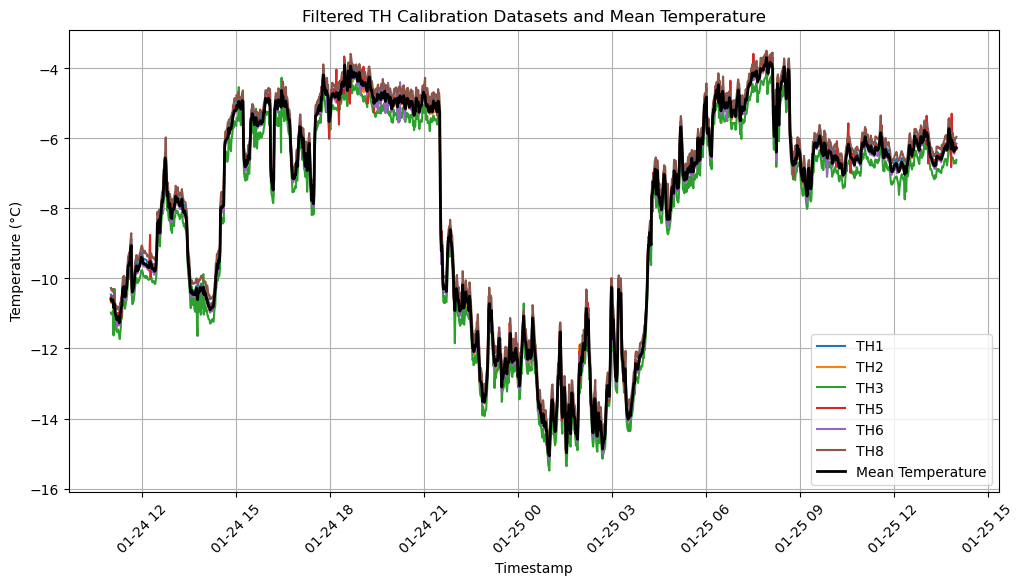

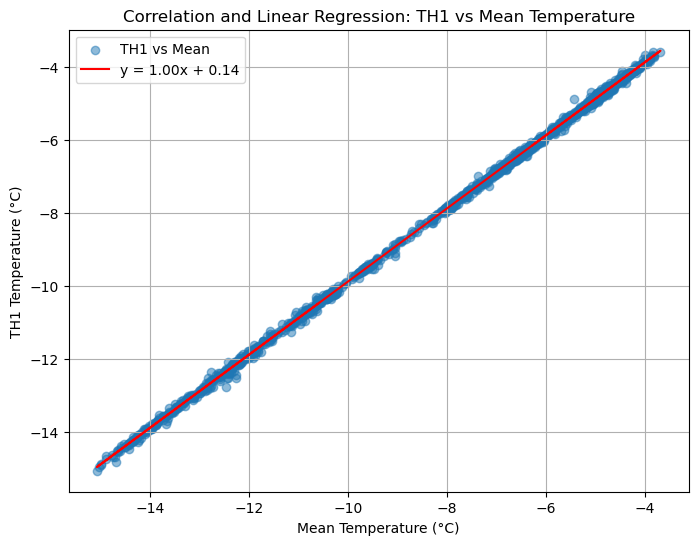

TH1 Linear Regression: y = 1.00x + 0.14


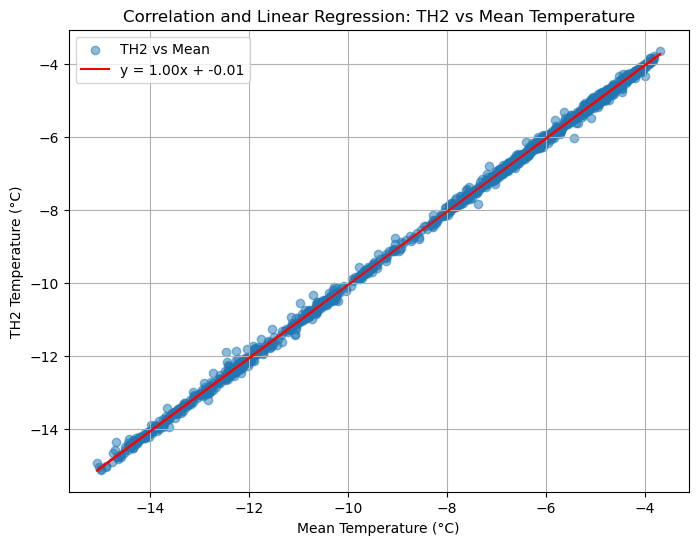

TH2 Linear Regression: y = 1.00x + -0.01


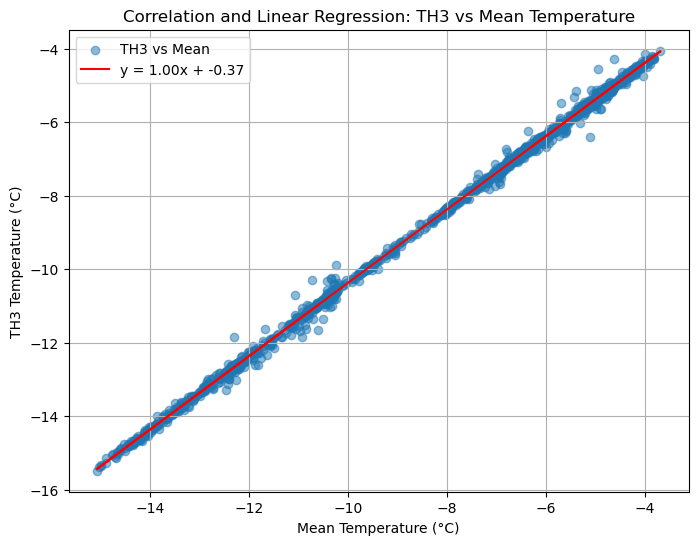

TH3 Linear Regression: y = 1.00x + -0.37


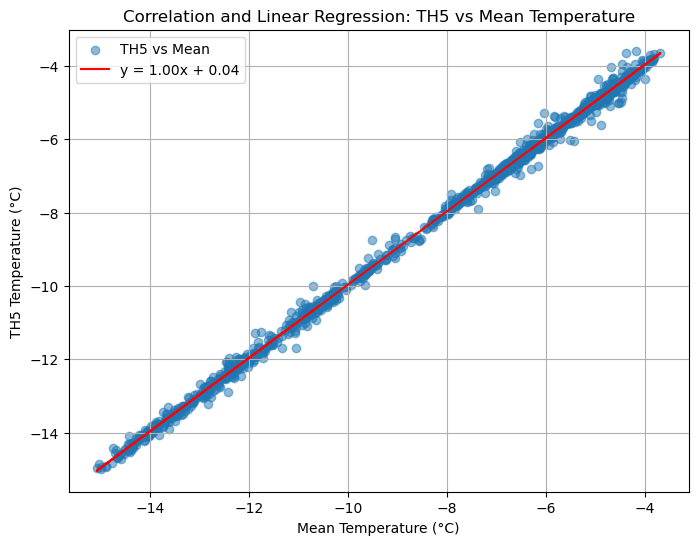

TH5 Linear Regression: y = 1.00x + 0.04


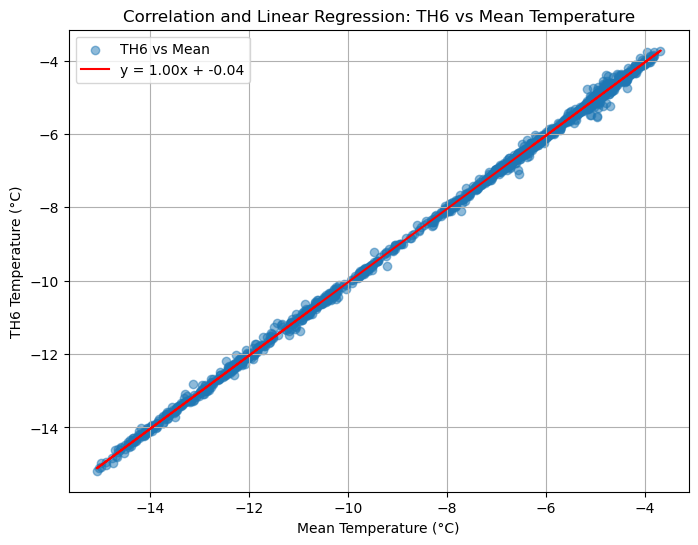

TH6 Linear Regression: y = 1.00x + -0.04


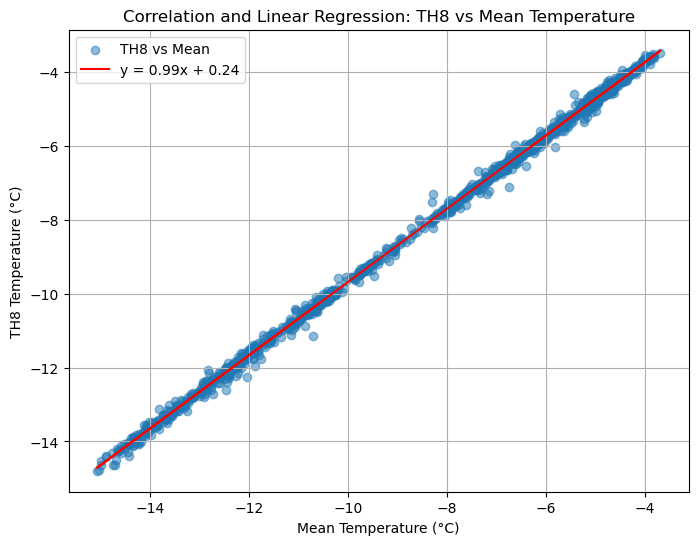

TH8 Linear Regression: y = 0.99x + 0.24


In [43]:
#import pandas as pd
#import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression

# Define the start and end dates for filtering
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

# List of TH calibration data variables
th_data_stations = [
    TH_calibration_data['TH1_calibration_data'],
    TH_calibration_data['TH2_calibration_data'],
    TH_calibration_data['TH3_calibration_data'],
    TH_calibration_data['TH5_calibration_data'],
    TH_calibration_data['TH6_calibration_data'],
    TH_calibration_data['TH8_calibration_data']
]

# Filter the datasets based on the specified start and end dates
filtered_th_data_stations = [
    df.loc[calibration_filter_start_date:calibration_filter_end_date, 'T_degC'] for df in th_data_stations
]

# Combine all filtered TH datasets into a single DataFrame
combined_df = pd.concat(filtered_th_data_stations, axis=1)
combined_df.columns = ['TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8']

# Calculate the mean temperature per timestep
mean_temp = combined_df.mean(axis=1)

# Plot all filtered TH datasets together
plt.figure(figsize=(12, 6))
for station in combined_df.columns:
    plt.plot(combined_df.index, combined_df[station], label=station)

# Add the mean temperature to the plot
plt.plot(mean_temp.index, mean_temp, label="Mean Temperature", color="black", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.title("Filtered TH Calibration Datasets and Mean Temperature")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Store the regression models
regression_models = {}


# Plot correlation of each TH dataset against the mean temperature
for station in combined_df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp, combined_df[station], alpha=0.5, label=f"{station} vs Mean")
    
    # Perform linear regression
    x = mean_temp.values.reshape(-1, 1)
    y = combined_df[station].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Store the regression model
    regression_models[station] = model
    

    # Plot the regression line
    plt.plot(mean_temp, y_pred, color="red", label=f"y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")
    
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Correlation and Linear Regression: {station} vs Mean Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the regression coefficients
    print(f"{station} Linear Regression: y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")





In [44]:
TH_calibration_data['TH5_calibration_data'].index

DatetimeIndex(['2025-01-24 11:00:00', '2025-01-24 11:01:00',
               '2025-01-24 11:02:00', '2025-01-24 11:03:00',
               '2025-01-24 11:04:00', '2025-01-24 11:05:00',
               '2025-01-24 11:06:00', '2025-01-24 11:07:00',
               '2025-01-24 11:08:00', '2025-01-24 11:09:00',
               ...
               '2025-01-25 13:51:00', '2025-01-25 13:52:00',
               '2025-01-25 13:53:00', '2025-01-25 13:54:00',
               '2025-01-25 13:55:00', '2025-01-25 13:56:00',
               '2025-01-25 13:57:00', '2025-01-25 13:58:00',
               '2025-01-25 13:59:00', '2025-01-25 14:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=1621, freq=None)

## Filter TT tinytags

remove TT data before and after red lines

In [45]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in TT_calibration_data.keys():
    df = TT_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    TT_calibration_data[key] = filtered_df

plot the filtered data

Text(0.5, 0, 'Time')

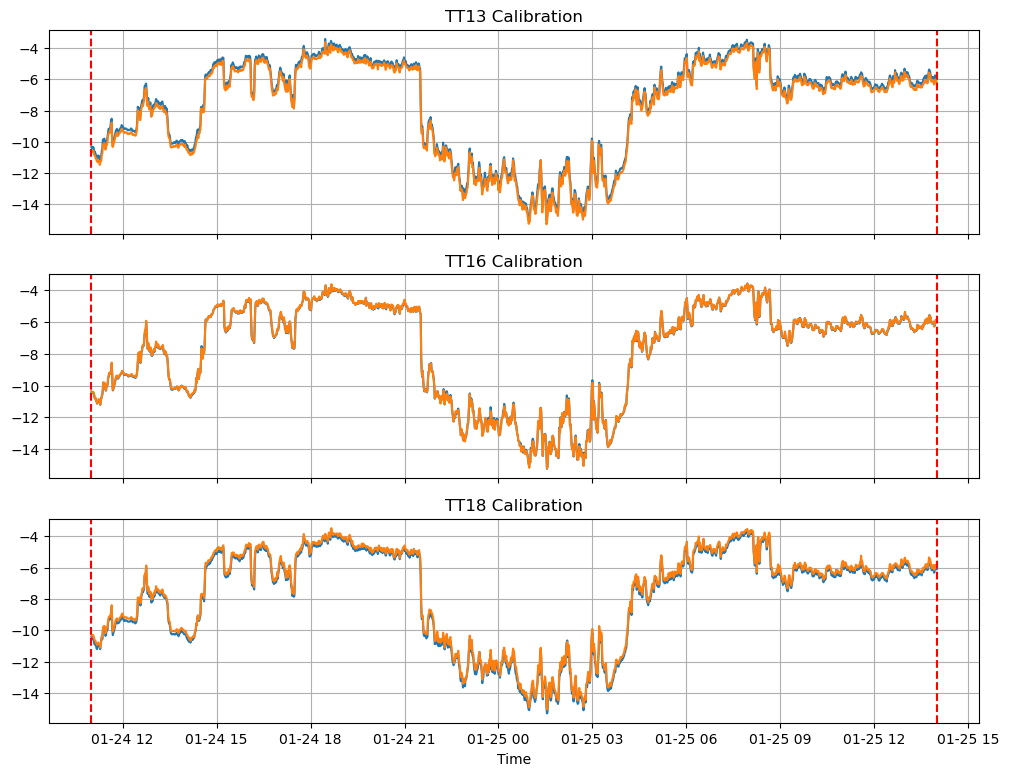

In [47]:
# # Get all dataset keys dynamically based on TinyTag_str
dataset_keys = sorted({f"{tag.split('_')[0]}_calibration_data" for tag in TinyTag_str 
                        if tag.startswith("TT") and tag.endswith(("_low", "_high")) and f"{tag.split('_')[0]}_calibration_data" in TT_calibration_data})


# # Adjust nrows based on the actual number of TH datasets
fig, ax = plt.subplots(nrows=len(dataset_keys), sharex=True, figsize=(12, 3 * len(dataset_keys)))

# # Ensure ax is always iterable (for single subplot cases)
if len(dataset_keys) == 1:
     ax = [ax]

# # Loop through each subplot and dataset
for i, key in enumerate(dataset_keys):
     ax[i].plot(TT_calibration_data[key].index, 
                TT_calibration_data[key].T_black_degC, label=f'{key} black'.replace("_calibration_data", ""))
     ax[i].plot(TT_calibration_data[key].index, 
                TT_calibration_data[key].T_white_degC, label=f'{key} white'.replace("_calibration_data", ""))
     ax[i].set_title(f"{key.replace('_calibration_data', '')} Calibration")

#     # Add vertical lines
     ax[i].axvline(x=calibration_filter_start_date, color='red', linestyle='--')
     ax[i].axvline(x=calibration_filter_end_date, color='red', linestyle='--')

     ax[i].grid(True)  # Enable grid

# # Set x-axis label only on the last subplot
ax[-1].set_xlabel("Time")


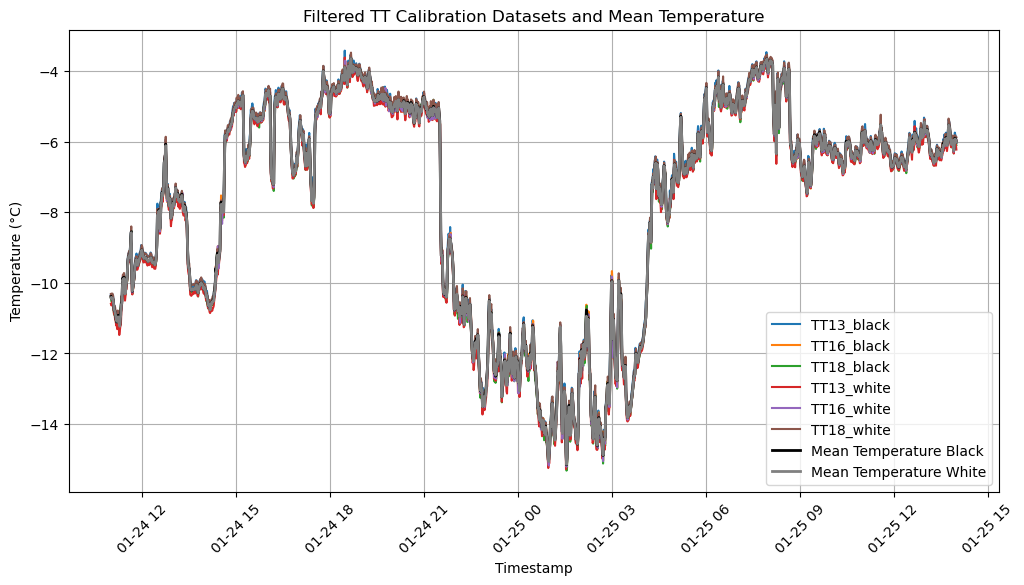

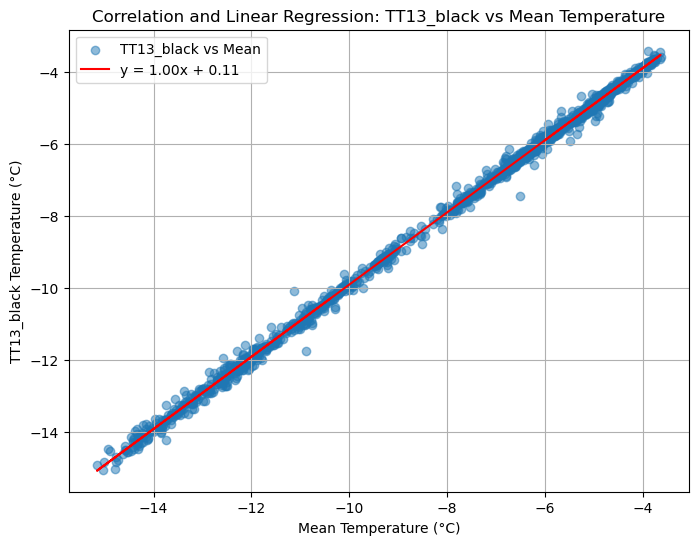

TT13_black Linear Regression: y = 1.00x + 0.11


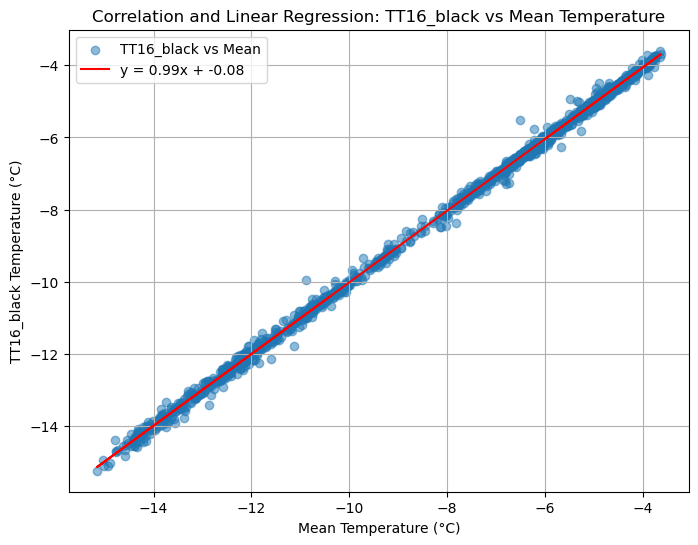

TT16_black Linear Regression: y = 0.99x + -0.08


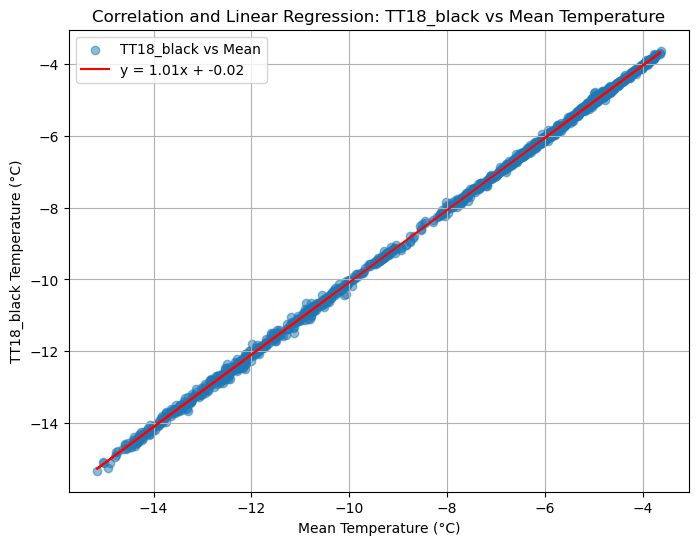

TT18_black Linear Regression: y = 1.01x + -0.02


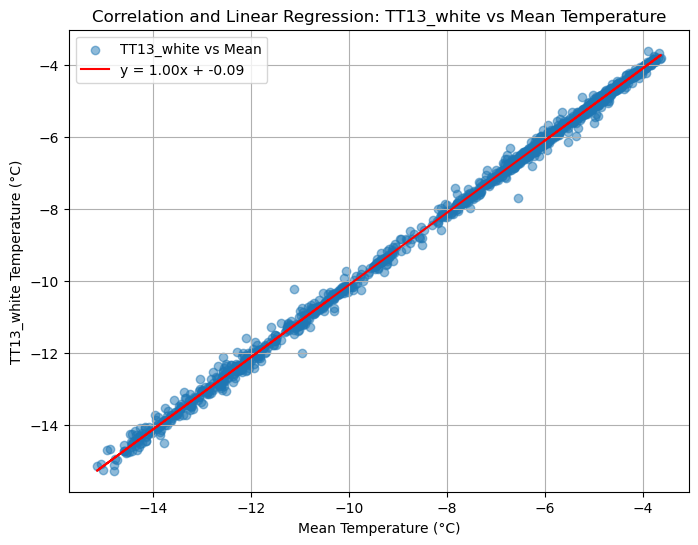

TT13_white Linear Regression: y = 1.00x + -0.09


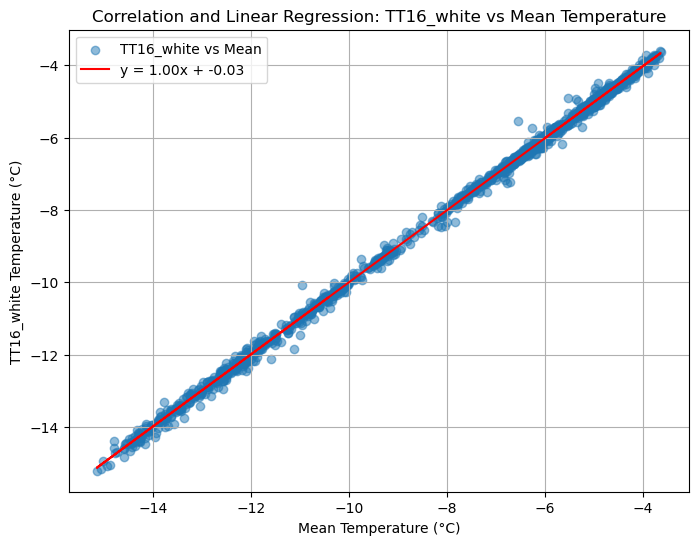

TT16_white Linear Regression: y = 1.00x + -0.03


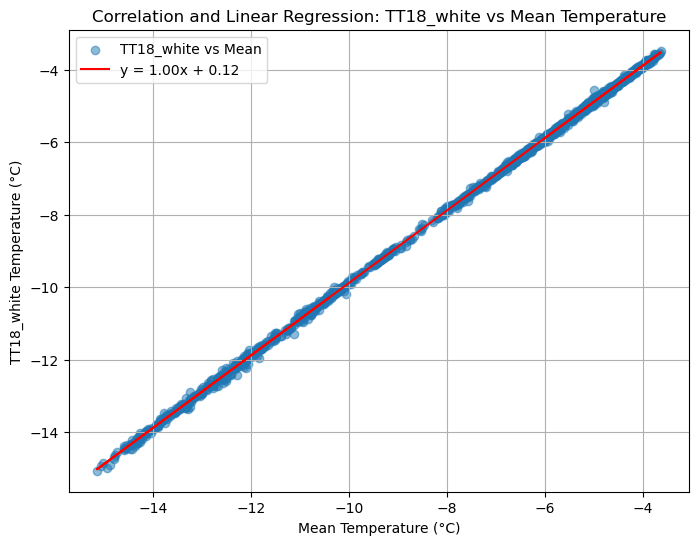

TT18_white Linear Regression: y = 1.00x + 0.12


In [61]:
#import pandas as pd
#import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression

# Define the start and end dates for filtering
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

# List of TT calibration data variables
tt_data_stations = [
    TT_calibration_data['TT13_calibration_data'],
    TT_calibration_data['TT16_calibration_data'],
    TT_calibration_data['TT18_calibration_data']
]

# Filter the datasets based on the specified start and end dates
filtered_tt_data_stations_black = [
    df.loc[calibration_filter_start_date:calibration_filter_end_date, 'T_black_degC'] for df in tt_data_stations
]

filtered_tt_data_stations_white = [
    df.loc[calibration_filter_start_date:calibration_filter_end_date, 'T_white_degC'] for df in tt_data_stations
]

# Combine all filtered TT datasets into a single DataFrame
combined_df_black = pd.concat(filtered_tt_data_stations_black, axis=1)
combined_df_black.columns = ['TT13_black', 'TT16_black', 'TT18_black']

combined_df_white = pd.concat(filtered_tt_data_stations_white, axis=1)
combined_df_white.columns = ['TT13_white', 'TT16_white', 'TT18_white']

# Calculate the mean temperature per timestep
mean_temp_black = combined_df_black.mean(axis=1)
mean_temp_white = combined_df_white.mean(axis=1)

# Plot all filtered TT datasets together
plt.figure(figsize=(12, 6))
for station in combined_df_black.columns:
    plt.plot(combined_df_black.index, combined_df_black[station], label=station)

for station in combined_df_white.columns:
    plt.plot(combined_df_white.index, combined_df_white[station], label=station)

# Add the mean temperature to the plot
plt.plot(mean_temp_black.index, mean_temp_black, label="Mean Temperature Black", color="black", linewidth=2)
plt.plot(mean_temp_white.index, mean_temp_white, label="Mean Temperature White", color="gray", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.title("Filtered TT Calibration Datasets and Mean Temperature")
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Store the regression models
regression_models = {}

# Plot correlation of each TT dataset against the mean temperature
for station in combined_df_black.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp_black, combined_df_black[station], alpha=0.5, label=f"{station} vs Mean")
    
    # Perform linear regression
    x = mean_temp_black.values.reshape(-1, 1)
    y = combined_df_black[station].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Store the regression model
    regression_models[station] = model
    

    # Plot the regression line
    plt.plot(mean_temp_black, y_pred, color="red", label=f"y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")
    
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Correlation and Linear Regression: {station} vs Mean Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the regression coefficients
    print(f"{station} Linear Regression: y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")

for station in combined_df_white.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_temp_white, combined_df_white[station], alpha=0.5, label=f"{station} vs Mean")
    
    # Perform linear regression
    x = mean_temp_white.values.reshape(-1, 1)
    y = combined_df_white[station].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Store the regression model
    regression_models[station] = model
    

    # Plot the regression line
    plt.plot(mean_temp_white, y_pred, color="red", label=f"y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")
    
    plt.xlabel("Mean Temperature (°C)")
    plt.ylabel(f"{station} Temperature (°C)")
    plt.title(f"Correlation and Linear Regression: {station} vs Mean Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print the regression coefficients
    print(f"{station} Linear Regression: y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}")

In [57]:
filtered_df

,RECORD,T_black_degC,T_white_degC
TIMESTAMP,,,
2025-01-24 11:00:00,70,-10.461,-10.492
2025-01-24 11:01:00,71,-10.583,-10.721
2025-01-24 11:02:00,72,-10.539,-10.770
2025-01-24 11:03:00,73,-10.628,-10.796
2025-01-24 11:04:00,74,-10.653,-10.804
...,...,...,...
2025-01-25 13:56:00,1686,-6.079,-6.162
2025-01-25 13:57:00,1687,-5.982,-6.071
2025-01-25 13:58:00,1688,-6.037,-6.130


## Filter the measured Tinytag data

In [ ]:
# TT_data['TT12_normal_data']
# TH_data['TH1_normal_data']
# ceb_data['CEB_1_normal_data']

# manual_times['TT12_high']
# manual_times['TH1']
# manual_times['CEB3']


In [55]:
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    """
    Filters TinyTag datasets by removing:
      - Data before the setup time
      - Data after the retrieval time
      - Data during the maintenance period (if applicable).
    
    If a dataset does NOT have a corresponding entry in `manual_times`, it is EXCLUDED from `filtered_data`.

    Parameters:
        data_dict (dict): Dictionary containing dataset DataFrames.
        manual_times (dict): Dictionary containing setup, maintenance, and retrieval times.
        prefix (str): Prefix for dataset type (e.g., 'TT', 'TH', 'CEB').

    Returns:
        dict: Filtered dataset dictionary (excluding datasets without matching time data).
    """
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)  # Extracts the number from "TT12_normal_data"
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)  # Extracts the number from "TH1_normal_data"
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)  # Extracts the number from "CEB_1_normal_data"
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times (e.g., "TT12_high", "TH1", "CEB3")
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            if matching_keys:
                # Assume first found key is the correct match
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                # Compute maintenance end time if applicable
                maintenance_end = maintenance_start + pd.Timedelta(minutes=maintenance_duration) if pd.notna(maintenance_start) else None

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]
                
                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))]

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data


In [58]:
filtered_data = filter_data_based_on_time_tinytag(TT_data, manual_times, 'TT')
filtered_data

{'TT12_normal_data':                      RECORD  T_black_degC  T_white_degC
 TIMESTAMP                                              
 2025-01-26 13:56:00     301        -3.717        -3.179
 2025-01-26 13:57:00     302        -3.633        -3.249
 2025-01-26 13:58:00     303        -3.511        -3.209
 2025-01-26 13:59:00     304        -4.145        -4.009
 2025-01-26 14:00:00     305        -4.186        -3.997
 ...                     ...           ...           ...
 2025-02-03 12:51:00   11756         2.104         2.338
 2025-02-03 12:52:00   11757         2.108         2.349
 2025-02-03 12:53:00   11758         2.057         2.232
 2025-02-03 12:54:00   11759         1.912         2.113
 2025-02-03 12:55:00   11760         1.740         1.923
 
 [11460 rows x 3 columns],
 'TT13_normal_data':                      RECORD  T_black_degC  T_white_degC
 TIMESTAMP                                              
 2025-01-26 15:54:00     421        -4.858        -5.048
 2025-01-26 15:55:0

In [59]:
# Apply filtering to each dataset type with the correct prefix
TH_data_filtered = filter_data_based_on_time_tinytag(TH_data, manual_times, "TH")
TT_data_filtered = filter_data_based_on_time_tinytag(TT_data, manual_times, "TT")
ceb_data_filtered = filter_data_based_on_time_tinytag(ceb_data, manual_times, "CEB")

In [60]:
for key in TH_data_filtered.keys():
    df = TH_data_filtered[key]
    
    # Rename column if it exists
    if "RH_%RH" in df.columns:
        df = df.rename(columns={"RH_%RH": "RH"})
        TH_data_filtered[key] = df  # Update the dataset

Filter CEB data

In [ ]:
#import pandas as pd
#import numpy as np
#import re
#from sklearn.linear_model import LinearRegression

# Define the function to filter data based on time
def filter_data_based_on_time_tinytag(data_dict, manual_times, prefix):
    filtered_data = {}

    for key, df in data_dict.items():
        # Extract the numeric identifier based on the dataset prefix
        if prefix == "TT":
            match = re.search(r'TT(\d+)', key)
        elif prefix == "TH":
            match = re.search(r'TH(\d+)', key)
        elif prefix == "CEB":
            match = re.search(r'CEB_(\d+)', key)
        else:
            match = None

        dataset_id = match.group(1) if match else None

        if dataset_id:
            # Look for a matching key in manual_times
            matching_keys = [manual_key for manual_key in manual_times if f"{prefix}{dataset_id}" in manual_key]

            if matching_keys:
                manual_key = matching_keys[0]
                times = manual_times[manual_key]

                setup_time = times['setup_time']
                retrieval_time = times['retrieval_time']
                maintenance_start = times['maintenance_start_time']
                maintenance_duration = times['maintenance_duration']

                maintenance_end = maintenance_start + pd.Timedelta(minutes=maintenance_duration) if pd.notna(maintenance_start) else None

                # Apply setup and retrieval filtering
                df_filtered = df[(df.index >= setup_time) & (df.index <= retrieval_time)]
                
                # Remove data within maintenance period if applicable
                if pd.notna(maintenance_start) and maintenance_end is not None:
                    df_filtered = df_filtered[~((df_filtered.index >= maintenance_start) & (df_filtered.index <= maintenance_end))]

                # Store the filtered DataFrame
                filtered_data[key] = df_filtered

    return filtered_data

# Define the function to calibrate the CEB datasets
def calibrate_ceb_data(ceb_data, regression_models):
    calibrated_data = {}

    for station, df in ceb_data.items():
        if station in regression_models:
            model = regression_models[station]
            df['Calibrated_Temperature'] = df['Temperature'].apply(lambda x: model.predict([[x]])[0][0] if not np.isnan(x) else np.nan)
            calibrated_data[station] = df

    return calibrated_data

# Example usage
# Assuming you have the following variables defined:
# ceb_data: Dictionary containing the CEB datasets
# manual_times: Dictionary containing the setup, maintenance, and retrieval times
# regression_models: Dictionary containing the linear regression models for each CEB station

# Filter the CEB datasets
filtered_ceb_data = filter_data_based_on_time_tinytag(ceb_data, manual_times, 'CEB')

# Calibrate the filtered CEB datasets
calibrated_ceb_data = calibrate_ceb_data(filtered_ceb_data, regression_models)

# Print or plot the calibrated data
for station, df in calibrated_ceb_data.items():
    print(f"Calibrated data for {station}:")
    print(df.head())